Thanks to Scikit-learn's `instantiate-fit-tranform-predict` template, we can run our formatted data through as many model as we like without having to continue to transform the data to fit each kind of model. <br>


In Scikit-learn our main concern is optimazing the models. 

For supervised problems, 
- we know the target so we can score the model, 
- we can easily throw the data at all different classifiers and 
- score them to find the optimal classifier.

We can automate these steps but the difficulties for automation are:
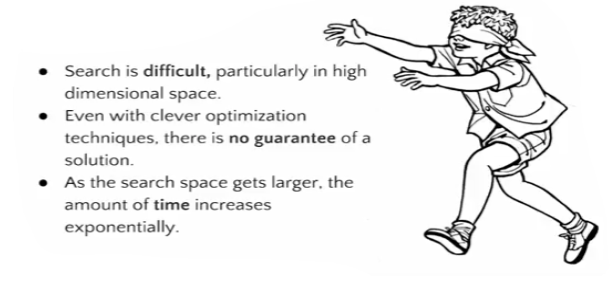

<!-- TEASER_END -->

- For a thightly constrained hyperparameter space optimization tools might work. 
- `GridSearch` can work if we have a known range of our hyperparameters.
- As hyperparameter space get larger it turns into a blind search

So in order to enhance the 
- feature selection, 
- feature engineering, 
- model selection and 
- hyperparameter tuning we will try to utilize some tools for visualization of some machine learning steps.

Being capable of visualizing these steps helps us to get the advantage of using our intiution for ML problems.

In this notebook we will work on `Bikes rental dataset` to utilize the visualization tools for feature selection

## Outline:
- About Dataset
- Data Summary
- Feature Engineering
- Outlier Analysis
- Visualizing Distribution Of Data
- Feature Selection
- Correlation Analysis
- Plot of Correlated Columns
- Dealing with the Input Errors
- Visualizing Riders Monthly, Daily, Hourly

## About dataset

- This dataset contains the hourly count of rental bikes between years 2011 and 2012 with the corresponding `weather` and `seasonal` information.
- In bike sharing systems, like Vilo in Brussels, whole process from membership, rental and return back has become automatic.
- Through these systems, user is able to easily rent a bike from a particular position and return back at another position. 
- The characteristics of data being generated by these systems make them attractive for the research. 

- The duration of travel, departure and arrival position is explicitly recorded in these systems. 
- This feature turns bike sharing system into a virtual sensor network that can be used for sensing mobility in the city. 
- Hence, it is expected that most of important events in the city could be detected via monitoring these data.

## Kaggle terms for the dataset:

- The training set is comprised of the first `19 days` of each month, while the test set is the `20th` to the end of the month. 

- Predict the `total count of bikes rented during each hour` covered by the test set, using only `information available prior to the rental period`.

Here is the [Kaggle link for the dataset](https://www.kaggle.com/c/bike-sharing-demand/data)

In [6]:
# Import the necessary modules
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

import warnings 
warnings.filterwarnings("ignore")
%matplotlib inline

sns.set()

## Data Summary

In [7]:
# Read the bikeshare data
bike_data=pd.read_csv("train.csv", parse_dates=["datetime"], index_col="datetime")
bike_data.head(3)

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
datetime,,,,,,,,,,,
2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16
2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40
2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32


In [8]:
# Get the summary of the dataset
bike_data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 10886 entries, 2011-01-01 00:00:00 to 2012-12-19 23:00:00
Data columns (total 11 columns):
season        10886 non-null int64
holiday       10886 non-null int64
workingday    10886 non-null int64
weather       10886 non-null int64
temp          10886 non-null float64
atemp         10886 non-null float64
humidity      10886 non-null int64
windspeed     10886 non-null float64
casual        10886 non-null int64
registered    10886 non-null int64
count         10886 non-null int64
dtypes: float64(3), int64(8)
memory usage: 1020.6 KB


### Descriptions of Some Data Fields

- `datetime` - hourly date + timestamp  
- `season` -  1 = winter, 2 = spring, 3 = summer, 4 = automn 
- `holiday` - whether the day is considered a holiday
- `workingday` - whether the day is neither a weekend nor holiday
- `weather:`
    - 1: Clear, Few clouds, Partly cloudy, Partly cloudy
    - 2: Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist
    - 3: Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds
    - 4: Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog 
- `temp` - temperature in Celsius
- `atemp` - "feels like" temperature in Celsius
- `humidity` - relative humidity
- `windspeed` - wind speed
- `casual` - number of non-registered user rentals initiated
- `registered` - number of registered user rentals initiated
- `count` - number of total rentals

## Feature Engineering

Since bike usage is very related with the hours of the day or months of the years it can be a good idea to extract these as features from the date.

Lets create new columns: `"hour", "weekday"` and `"month"`

In [9]:
bike_data["month"]=bike_data.index.month
bike_data["weekday"]=bike_data.index.dayofweek
bike_data["hour"]=bike_data.index.hour
bike_data.head(3)

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,month,weekday,hour
datetime,,,,,,,,,,,,,,
2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16,1,5,0
2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40,1,5,1
2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32,1,5,2


## Outliers Analysis
Let's take a look at the difference between the `mean` and `median` of some columns to detect the existence of outlier values.

In [10]:
bike_data[["temp", "atemp", "humidity", "windspeed", "count"]].describe()

,temp,atemp,humidity,windspeed,count
count,10886.00000,10886.000000,10886.000000,10886.000000,10886.000000
mean,20.23086,23.655084,61.886460,12.799395,191.574132
std,7.79159,8.474601,19.245033,8.164537,181.144454
min,0.82000,0.760000,0.000000,0.000000,1.000000
25%,13.94000,16.665000,47.000000,7.001500,42.000000
50%,20.50000,24.240000,62.000000,12.998000,145.000000
75%,26.24000,31.060000,77.000000,16.997900,284.000000
max,41.00000,45.455000,100.000000,56.996900,977.000000


We notice that `count` column has a big mean- median difference. Now see the boxplot  and distribution of `count` column.

##  Visualizing Distribution Of Data

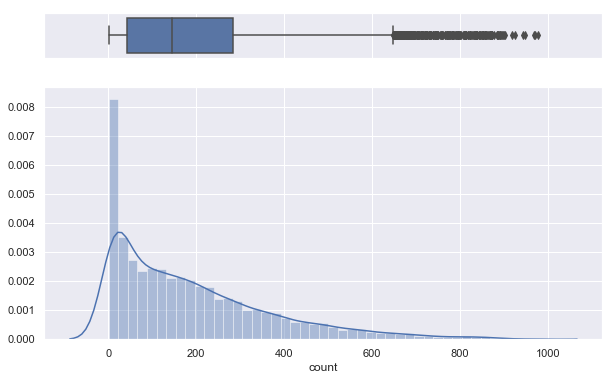

In [11]:
# Create a figure and two axes for boxplot and distplot
fig, (ax_box, ax_dist) = plt.subplots(nrows=2, sharex=True, figsize=(10, 6), gridspec_kw={"height_ratios": (.15, .85)})
 
# Plot the boxplot on the ax_box axis
sns.boxplot(bike_data["count"], ax=ax_box)


# Plot the distplot on the ax_dist axis
sns.distplot(bike_data["count"], ax=ax_dist)
 
# Remove xlabel for the boxplot
ax_box.set(xlabel='');

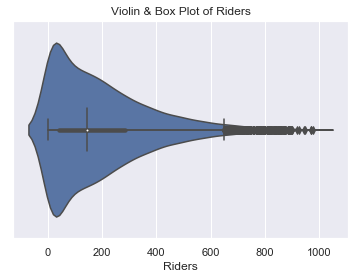

In [12]:
# Plot the boxplot
ax=sns.boxplot(x="count", data=bike_data, width=0.2, orient="h")

# Add the violinplot on the same figure
sns.violinplot(x="count", data=bike_data, bw=.2, orient="h")

# Add the label and title
ax.set(xlabel='Riders', title="Violin & Box Plot of Riders");

Seaborn boxplot whisker by default extend to the points which are `1.5 IQR` away from the upper and lower quartile. So we can see the outliers after the upper whisker. Let's move the outliers

In [13]:
# Remove the outliers
bike_data_inliers = bike_data.loc[bike_data["count"] <590, :]

# Reset the index of bike_data_inliers dataframe
bike_data_inliers.reset_index(inplace=True)

# Print the data size before and after the outliers
print ("Dataset size before outliers: ", len(bike_data))
print ("Dataset size after outliers: ", len(bike_data_inliers))

Dataset size before outliers:  10886
Dataset size after outliers:  10436


## Feature selection

After data preperation machine learning process usually followed by the questions:
- **"Which features should i use?"**
- **"Which features are predictive?"**

The machine learning workflow is the art of creating model selection triples:
- combination of features, 
- algorithm , and 
- hyperparameters that uniquely identifies a model fitted on a specific data set. 

As part of our `feature selection`, we want to
- identify features that have a `linear relationship` with each other, and 
- avoid using variables that have strong correlations with each other 


## Correlation Analysis

It is better to avoiding feature redundancy for a few reasons:
- To keep the model simple and improve interpretability 
- Too many features can lead us to the risk of overfitting.
- When our datasets are very large, using fewer features can speed up our computation time.

We will create the correlation matrix with pandas `.corr()` method

In [14]:
# The columns which will be taken into account for correlation analysis
bike_data_core= bike_data_inliers[["season", "month", "hour", "holiday", "weekday", "workingday","weather", "temp", "atemp", "humidity", "windspeed", "count"]]
# Create correlation matrix
corr_matx=bike_data_core.corr()
corr_matx

,season,month,hour,holiday,weekday,workingday,weather,temp,atemp,humidity,windspeed,count
season,1.000000,0.972084,-0.010110,0.031797,-0.007486,-0.013088,0.008366,0.266754,0.273228,0.197508,-0.149698,0.167106
month,0.972084,1.000000,-0.010347,0.004129,0.000628,-0.007765,0.012485,0.264717,0.271631,0.211162,-0.153324,0.169954
hour,-0.010110,-0.010347,1.000000,0.001839,0.002452,-0.002295,-0.016116,0.128684,0.123972,-0.266379,0.143242,0.433456
holiday,0.031797,0.004129,0.001839,1.000000,-0.194707,-0.251981,-0.008518,0.003416,-0.002025,-0.001139,0.007723,0.012368
weekday,-0.007486,0.000628,0.002452,-0.194707,1.000000,-0.703308,-0.043503,-0.036063,-0.037180,-0.020524,-0.026347,0.030138
workingday,-0.013088,-0.007765,-0.002295,-0.251981,-0.703308,1.000000,0.032207,0.027674,0.022406,-0.018295,0.015851,-0.023943
weather,0.008366,0.012485,-0.016116,-0.008518,-0.043503,0.032207,1.000000,-0.047558,-0.048180,0.404363,0.008896,-0.123600
temp,0.266754,0.264717,0.128684,0.003416,-0.036063,0.027674,-0.047558,1.000000,0.985822,-0.044500,-0.024146,0.388262
atemp,0.273228,0.271631,0.123972,-0.002025,-0.037180,0.022406,-0.048180,0.985822,1.000000,-0.023709,-0.065486,0.384670
humidity,0.197508,0.211162,-0.266379,-0.001139,-0.020524,-0.018295,0.404363,-0.044500,-0.023709,1.000000,-0.319056,-0.317623


With this table, at a glance it is not very easy to detect the high correlations. Maybe it is easier to make sense of the table when we fit some style to it.

In [15]:
# Fit a style to the table
corr_matx.style.background_gradient()

,season,month,hour,holiday,weekday,workingday,weather,temp,atemp,humidity,windspeed,count
season,1,0.972084,-0.0101103,0.0317974,-0.00748569,-0.0130877,0.00836561,0.266754,0.273228,0.197508,-0.149698,0.167106
month,0.972084,1,-0.0103473,0.00412879,0.000628289,-0.00776512,0.0124848,0.264717,0.271631,0.211162,-0.153324,0.169954
hour,-0.0101103,-0.0103473,1,0.00183947,0.00245159,-0.00229494,-0.0161162,0.128684,0.123972,-0.266379,0.143242,0.433456
holiday,0.0317974,0.00412879,0.00183947,1,-0.194707,-0.251981,-0.00851763,0.00341622,-0.00202474,-0.00113902,0.00772344,0.0123677
weekday,-0.00748569,0.000628289,0.00245159,-0.194707,1,-0.703308,-0.0435033,-0.0360634,-0.0371795,-0.0205236,-0.0263469,0.0301381
workingday,-0.0130877,-0.00776512,-0.00229494,-0.251981,-0.703308,1,0.0322065,0.0276741,0.0224056,-0.0182948,0.0158506,-0.023943
weather,0.00836561,0.0124848,-0.0161162,-0.00851763,-0.0435033,0.0322065,1,-0.0475582,-0.0481797,0.404363,0.00889583,-0.1236
temp,0.266754,0.264717,0.128684,0.00341622,-0.0360634,0.0276741,-0.0475582,1,0.985822,-0.0444996,-0.0241457,0.388262
atemp,0.273228,0.271631,0.123972,-0.00202474,-0.0371795,0.0224056,-0.0481797,0.985822,1,-0.0237089,-0.0654858,0.38467
humidity,0.197508,0.211162,-0.266379,-0.00113902,-0.0205236,-0.0182948,0.404363,-0.0444996,-0.0237089,1,-0.319056,-0.317623


- It looks better but still not very descriptive 
- Especially with large number of features this table can be hard to use
- Extra filtering can help us to select the relevant values.
- We can filter out the correlation values which are greater than `0.75` and not equal to `1`. 
- The values equal to `1` are the diagonal values.

In [16]:
# Create a boolean mask of the given conditions
# Use absolute value function to get the negative correlations also
corr_mask= corr_matx.apply(lambda col: (abs(col)> 0.75) & (abs(col)!=1))

# Count the True values in each column
corr_mask.sum()

season        1
month         1
hour          0
holiday       0
weekday       0
workingday    0
weather       0
temp          1
atemp         1
humidity      0
windspeed     0
count         0
dtype: int64

By the count of `True` values we detected high correlations in `"season, month, atemp, temp"` columns.<br> 
We can identify the relations by checking the above table particularly for these columns<br>
Filtering out the strong correlation by computing like this is always important especially for large dataset because visualization is not quantifiable. 

Still having a en efficient visual tool would be great.

- Here we will utilize the `Rank2D` visualizer of Yellowbrick library to compute `Pearson` correlations between all pairs of features.

- Yellowbrick classes are compatible with the Sklearn `import-instantiate-fit-transform-predict` template
- Yellowbrick visualizers are using Matplotlib under the hood so we can apply the axes and figure functions to these visualizers

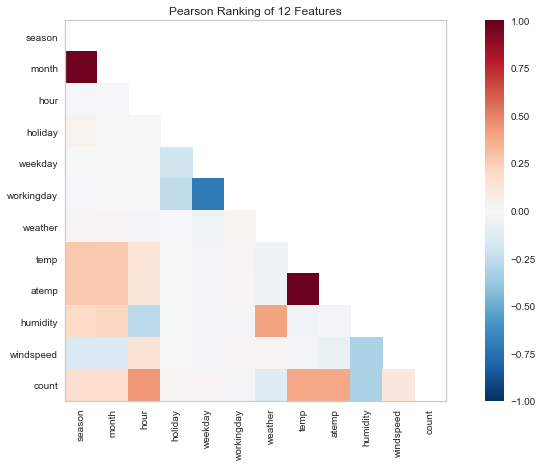

In [17]:
# Import Rank2D class from yellowbrick
from yellowbrick.features import Rank2D

# Modify the figure size
fig, ax=plt.subplots(figsize=(14,7))

# Instantiate the Rank2D object with default arguments: visualizer
visualizer = Rank2D(algorithm="pearson")

# fit the visualizer
visualizer.fit_transform(bike_data_core)

# Plot the visualizer with .poof() method
visualizer.poof()

- This figure shows us the Pearson correlation between pairs of features 
- Density of the colors displays the magnitude of the correlation. 
- A Pearson correlation of 
    - `1.0` means that there is a strong positive, linear relationship between the pairs of variables and 
    - `-1.0` indicates a strong negative, linear relationship (a value of zero indicates no relationship). 
- Therefore we are looking for `dark red` and `dark blue` boxes to identify strong correlations.

In this chart, we see that the features 
- `temp` and `atemp` and
- `season` and `month` columns have a strong correlation

This seems to make sense; 
- the `apparent temperature` we feel outside depends on the `actual temperature` and other airquality factors, and 
- the `season` of the year is described by the `month`! 

In the above cells we found the same result by filtering out but having a visual table like this is awesome again especially for larger datasets

## Plot of Correlated Columns
Now lets plot the `temp` and `atemp` columns to see closely 

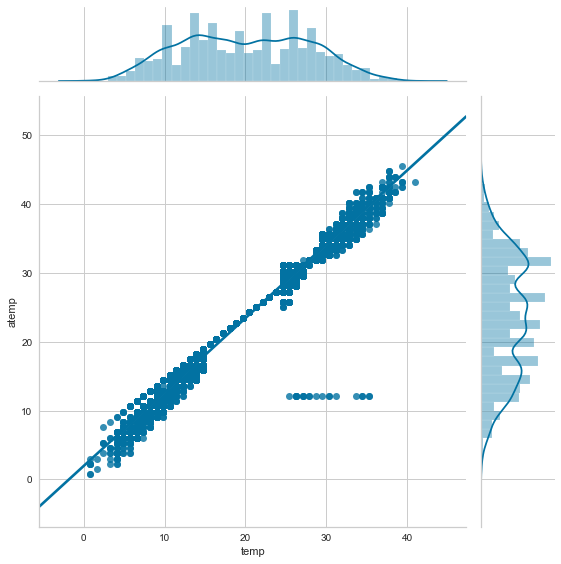

In [18]:
# Use seaborn jointplot with kind=reg
g = sns.jointplot(x="temp", y= "atemp", data=bike_data_core, kind="reg", height=8)

Scatter diagram of 
- the `apparent temperature` on the y axis and 
- the `actual measured temperature` on the x axis and 
- draws a line of best fit using a simple linear regression. 


At-a-glance we we see 
- a very strong positive correlation of the features, 
- the range and distribution of each feature. 

- There appear to be some data errors in the dataset. 
- These instances may need to be `manually removed` in order to improve the quality of the final model  
    

- By just looking the above scatter diagram it is not possible which column caused the erreneous input. 
- Even though a horizontal line of data(constant y axis values), make us be suspicious about the input error in `atemp` column.
- We will manually find it them below    

- We can ultimately confirm the selection of the columns to remove by training our model on either value, and scoring the results. 

## Errenous inputs in "temp" or "atemp" columns

If we observe the values of `temp` or `atemp` column without pairing to each other, it is not easy to detect data input errors becasue these values are not extreme values regarding the range of `temp` and `atemp` columns. 

- Lets search them in pairs. 
- First subset the `bike_data` with the condition : 
    - `12< atemp <13`  or `25 <temp< 35` (because the outliers fall in that interval as seen in the scatter diagram)
    
- and select the columns `"hour, temp`, and `atemp"`

In [19]:
# Subset the relevant part of the bike_data: df_err
df_err= bike_data_inliers[(bike_data_inliers["atemp"]>12) & (bike_data_inliers["atemp"] <13)]
df_err= df_err[["hour", "temp", "atemp"]]
df_err.head()

,hour,temp,atemp
5,5,9.84,12.88
7,7,8.20,12.88
59,14,10.66,12.12
60,15,10.66,12.12
61,16,10.66,12.12


Lets plot and see this subset dataframe with error inputs: `df_err`

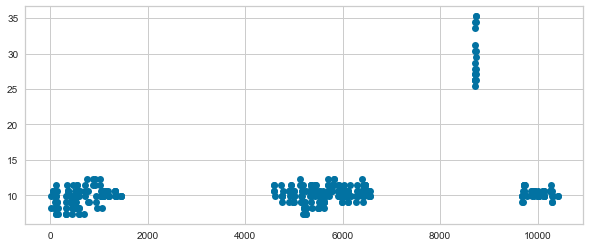

In [20]:
df_err.temp.plot(marker="o", linewidth=0, figsize=(10,4));

We can narrow down the index values of dataframe on the chart (x axis) by `xlim()` parameter of the plot method and find the index of outlier values

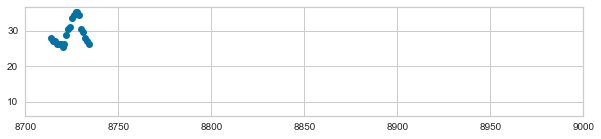

In [21]:
df_err.temp.plot(marker="o", linewidth=0, xlim=(8700, 9000), figsize=(10,2));

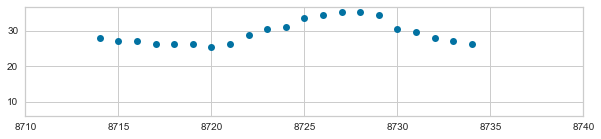

In [22]:
 df_err.temp.plot(marker="o", linewidth=0, xlim=(8710, 8740), figsize=(10,2));

Now we know where the erroneous inputs. Their index values are between `8710, 8740`. 
- Lets extract that slice of the `bike_data` and
- subset only the columns `"hour", "temp","atemp"` for the ease of observing and
- fit a styling on the erroneous inputs

In [23]:
# Inspect the range 13700:13730 of bike_data_inliers df
erroneous_df= bike_data_inliers.loc[8710: 8740, ["datetime", "temp","atemp"]]

def highlight_cols(s):
    color = 'yellow'
    return 'background-color: %s' % color

erroneous_df.style.applymap(highlight_cols, subset=pd.IndexSlice[8714:8734, "atemp"])

,datetime,temp,atemp
8710,2012-08-16 20:00:00,31.16,34.09
8711,2012-08-16 21:00:00,30.34,33.335
8712,2012-08-16 22:00:00,29.52,33.335
8713,2012-08-16 23:00:00,28.7,32.575
8714,2012-08-17 00:00:00,27.88,12.12
8715,2012-08-17 01:00:00,27.06,12.12
8716,2012-08-17 02:00:00,27.06,12.12
8717,2012-08-17 03:00:00,26.24,12.12
8718,2012-08-17 04:00:00,26.24,12.12
8719,2012-08-17 05:00:00,26.24,12.12


With this output we can see that erroneous inputs are in the `atemp` column. We can replace the erroneous input by interpolation.

In [24]:
# Extract the erroneous slice of atemp column
erroneous_slice=bike_data_inliers.loc[8712:8736, "atemp"]

# Replace the 0.2424 values with nan 
erroneous_slice.replace(12.12, np.nan, inplace=True)

erroneous_slice

8712    33.335
8713    32.575
8714       NaN
8715       NaN
8716       NaN
8717       NaN
8718       NaN
8719       NaN
8720       NaN
8721       NaN
8722       NaN
8723       NaN
8724       NaN
8725       NaN
8726       NaN
8727       NaN
8728       NaN
8729       NaN
8730       NaN
8731       NaN
8732       NaN
8733       NaN
8734       NaN
8735    28.790
8736    27.275
Name: atemp, dtype: float64

In [25]:
# Interpolate the nan values
erroneous_slice.interpolate()

8712    33.335000
8713    32.575000
8714    32.402955
8715    32.230909
8716    32.058864
8717    31.886818
8718    31.714773
8719    31.542727
8720    31.370682
8721    31.198636
8722    31.026591
8723    30.854545
8724    30.682500
8725    30.510455
8726    30.338409
8727    30.166364
8728    29.994318
8729    29.822273
8730    29.650227
8731    29.478182
8732    29.306136
8733    29.134091
8734    28.962045
8735    28.790000
8736    27.275000
Name: atemp, dtype: float64

In [26]:
# Replace the erroneous part of the data frame with the interpolated data
bike_data_inliers.loc[8712:8736, "atemp"]= erroneous_slice.interpolate()

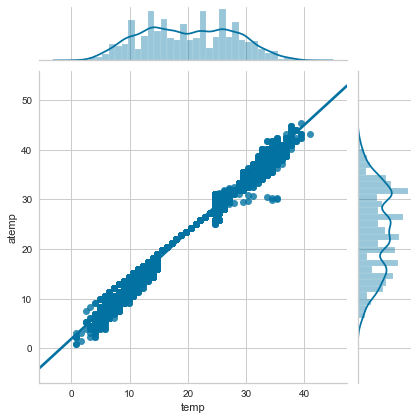

In [27]:
# Plot the "temp" and "atemp" columns again
g = sns.jointplot(x="temp", y= "atemp", data=bike_data_inliers, kind="reg", height=6)

It looks better.

## Visualizing Riders Monthly, Daily, Hourly

In the final section of this notebook we want to see the bike rental pantterns by the breakdown of time.
Since it is intiutive that bike usage is related with weather and time we expect to see meaningful relations on the charts.

Here is our steps:
- Since we are working with data created by humans with time it is a good practice to observe it by splitting into `"weekdays"` and `"weekends"`. <br> 
If it was a dataset created by butterflies of course we would not have done it this way!


- We will also start from the longer time frames and follow by the shorter time frames

We will do ploting repeatedly so it would be more efficient to define a plot function instead of writing the scripts again each time.

In [28]:
# Define a barplot function: bar_plot
def bar_plot(df, label_x, label_y, str_title):
    '''Takes a dataframe and three strings: label of x-axis, label of y-axis and title
        returns a bar plot'''
    plt.style.use('fivethirtyeight')
    fig, ax=plt.subplots()
    ax= df.plot(kind= "bar", 
                figsize=(10,5), 
                rot=70,
                fontsize=11)        
    ax.set_xlabel(label_x)
    ax.set_ylabel(label_y)
    ax.set_title(str_title)
    plt.show()

In [29]:
bike_data_inliers.dtypes

datetime      datetime64[ns]
season                 int64
holiday                int64
workingday             int64
weather                int64
temp                 float64
atemp                float64
humidity               int64
windspeed            float64
casual                 int64
registered             int64
count                  int64
month                  int64
weekday                int64
hour                   int64
dtype: object

In [30]:
#  Convert the date column to the datetimeindex
bike_data_inliers.set_index("datetime", inplace=True)

# Create the weekdays and weekends dataframes
weekdays=bike_data_inliers[bike_data_inliers.index.dayofweek.isin([0,1,2,3,4])]
weekends=bike_data_inliers[bike_data_inliers.index.dayofweek.isin([5, 6])]

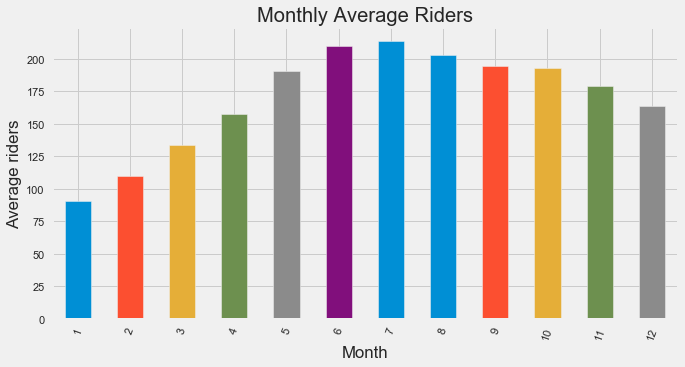

In [31]:
# Groupby montly average riders
monthly=bike_data_inliers.groupby(bike_data_inliers.index.month)["count"].mean()

# Plot the monthly bike rentals 
labelx= "Month"
labely="Average riders"
title= "Monthly Average Riders"
bar_plot(monthly, labelx, labely, title)

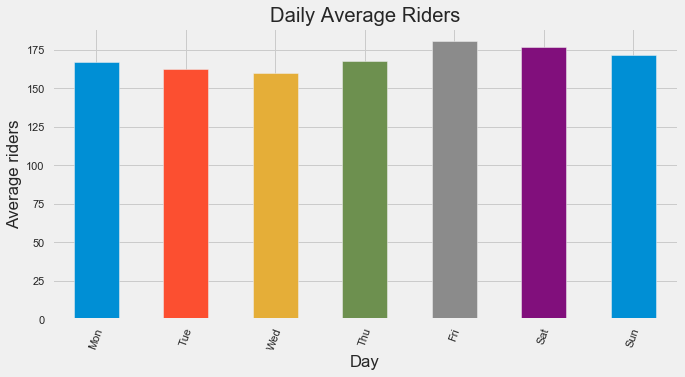

In [32]:
# Groupby the daily average bike rentals 
daily= bike_data_inliers.groupby(bike_data_inliers.index.dayofweek)["count"].mean()
daily.index=['Mon', 'Tue', 'Wed', 'Thu', 'Fri', "Sat", "Sun"]

# Plot the daily bike rentals 
labelx= "Day"
labely="Average riders"
title= "Daily Average Riders"
bar_plot(daily, labelx, labely, title)

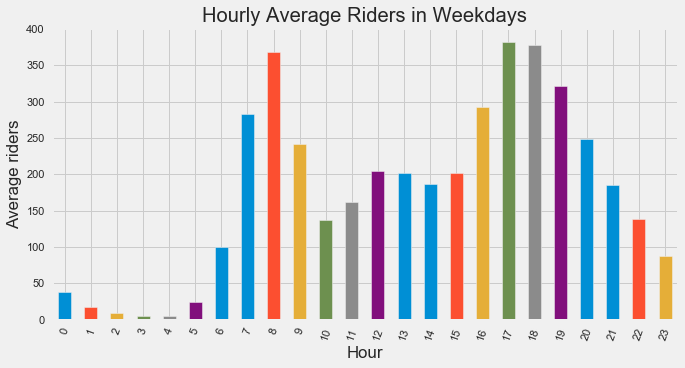

In [33]:
# Groupby weekdays data by the hourly average bike rentals 
hourly_weekdays= weekdays.groupby("hour")["count"].mean()

# Plot the hourly weekdays bike rentals 
labelx= "Hour"
labely="Average riders"
title= "Hourly Average Riders in Weekdays"
bar_plot(hourly_weekdays, labelx, labely, title)

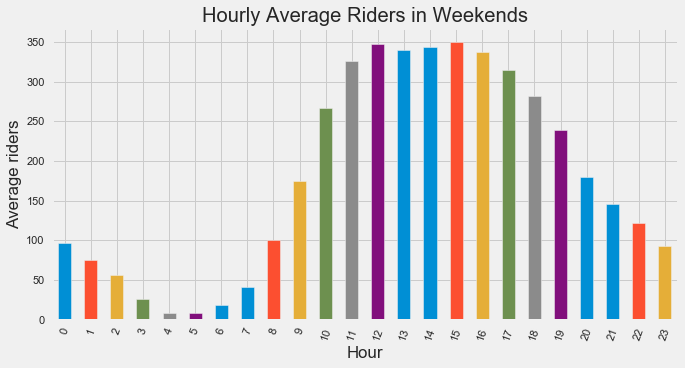

In [34]:
# Groupby weekdays data by the hourly average bike rentals 
hourly_weekends= weekends.groupby("hour")["count"].mean()


# Plot the hourly weekdays bike rentals 
labelx= "Hour"
labely="Average riders"
title= "Hourly Average Riders in Weekends"
bar_plot(hourly_weekends, labelx, labely, title)     

We can also plot the `sns.pointplot` to see the hourly rentals across all the days seperately on one chart.

Here is a brief info about the `sns.pointplot` from the offical documentation:
> A poinplot
- shows point estimates and confidence intervals using scatter plot glyphs.
- represents an estimate of central tendency for a numeric variable by the position of scatter plot points and provides some indication of the uncertainty around that estimate using error bars. (in our chart we are not displaying the bars)
- Point plots can be more useful than bar plots for focusing comparisons between different levels of one or more categorical variables. 
- They are particularly adept at **showing interactions**: how the relationship between levels of one categorical variable changes across levels of a second categorical variable. 
- The lines that join each point from the same hue level allow interactions **to be judged by differences in slope**, which is easier for the eyes than comparing the heights of several groups of points or bars.
- It is important to keep in mind that a pointplot shows **only the mean (or other estimator) value**, but in many cases it may be more informative to show the distribution of values at each level of the categorical variables. 
- In that case, other approaches such as a **box or violin plot** may be more appropriate.

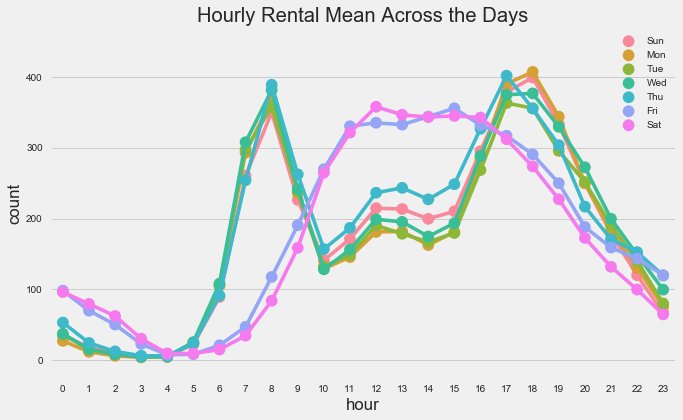

In [35]:
# Plot the hourly rental means in the weekdays and weekends on poinplot
fig, ax=plt.subplots(figsize=(10, 6))

sns.pointplot(x="hour", 
              y="count", 
              hue="weekday", 
              data=bike_data_inliers, 
              errwidth=0,
              scale=.5, 
              ax=ax);

hue_labels = ["Sun", "Mon","Tue","Wed","Thu","Fri","Sat"]
leg_handles = ax.get_legend_handles_labels()[0]
ax.legend(leg_handles, hue_labels);

ax.set_title("Hourly Rental Mean Across the Days");

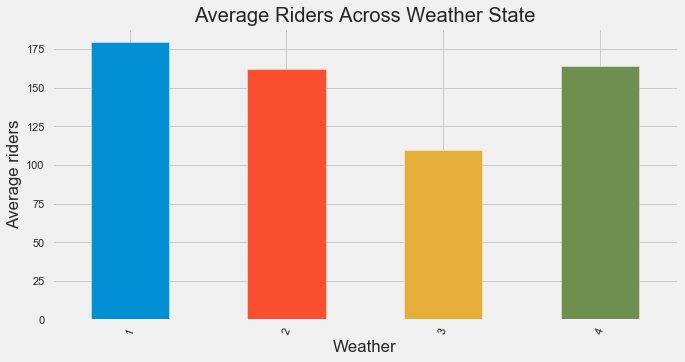

In [36]:
# Groupby by "weather" column and plot
weather_state=bike_data_inliers.groupby("weather")["count"].mean()


# Plot the average bike rentals across the weather state 
labelx= "Weather"
labely="Average riders"
title= "Average Riders Across Weather State"
bar_plot(weather_state, labelx, labely, title)     

##  Pointplot of weather state

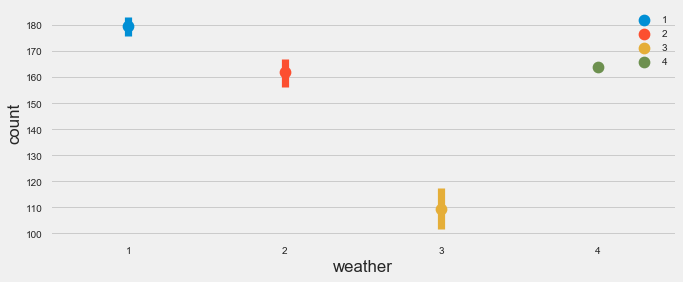

In [37]:
# Plot the hourly rentals in the weekdays and weekends on poinplot
fig, ax=plt.subplots(figsize=(10, 4))

sns.pointplot(x="weather", 
              y="count", 
              hue="weather", 
              data=bike_data_inliers, 
              scale=.5, 
              join=True,
              ax=ax);

hue_order = ["1", "2", "3", "4"]
leg_handles = ax.get_legend_handles_labels()[0]
ax.legend(leg_handles, hue_order);

Regarding the given description of `weather` column below,

    weather:
    1: Clear, Few clouds, Partly cloudy, Partly cloudy
    2: Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist
    3: Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds
    4: Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog

the chart above does not look like intiutive because the mean of rentals  at `state-4` are more than at `state-3`.

We should think about this and maybe question about the relaiblity of the `"weather"` column

## Wrap Up

In this notebook we

- explored the `bike rental dataset`
- did outlier analysis and removed the outliers
- made correlation analysis for future selection (in the next post)
- utilized Yellowbrick's visiualization tool for correlation matrix
- found out input errors by ploting the features and
- replaced the erroroneus input by interpolatation
- finally displayed the bike rentals in different time frames

During all steps we tried to get the advantage of visual tools in order to do out analysis more efficiently.

In the next post we will continue with the predictive analysis of the bike rentals and work on machine learning steps.

Sources: <br>
https://www.youtube.com/watch?v=2ZKng7pCB5k